# Description
In this notebook we show how to use pyMatchSeries in combination with Hyperspy to perform non-rigid-registration on image data as well as on spectroscopic data. The goal is to extract distortion effects from slow and fast scan noise and correct for them.

In [1]:
import hyperspy.api as hs
import os

/Users/nielscautaerts/opt/anaconda3/envs/devel/lib/python3.8/site-packages/pyUSID/viz/__init__.py:16: FutureWarning: Please use sidpy.viz.plot_utils instead of pyUSID.viz.plot_utils. pyUSID.plot_utils will be removed in a future release of pyUSID
  warn('Please use sidpy.viz.plot_utils instead of pyUSID.viz.plot_utils. '


## 1. Import the data, download if not already on system

In [2]:
file_path = "./data/sample_data.emd"

if not os.path.isfile(file_path):
    import wget
    print("File not found on system, downloading... please be patient")
    url = "https://owncloud.gwdg.de/index.php/s/hb7QFFl2EswRpZA/download"
    folder, filename = os.path.split(file_path)
    if not os.path.isdir(folder):
        os.makedirs(folder)
    wget.download(url, file_path)
    print("Finished downloading file")

## 2. Set up non-rigid registration calculation

In [3]:
from importlib import reload

In [4]:
from pymatchseries import io_tools as pio

In [10]:
reload(pio)

<module 'pymatchseries.io_tools' from '/Users/nielscautaerts/Documents/PythonProjects/pyMatchSeries/pymatchseries/io_tools.py'>

First we create a new MatchSeries object, providing the file path and a pre-processing function. You may also apply a number of options from the config file as keyword arguments. We change the config file a few cells down.

Instead of a file path to a .hspy or .emd file, you should also be able to supply a hs.signals.Signal2D or 3D numpy array

In [11]:
calculation = pio.MatchSeries.new(file_path, name = "minimal", output_folder="./data/minimal",
                              image_dataset_index = [5])

/Users/nielscautaerts/Documents/PythonProjects/pyMatchSeries/pymatchseries/io_tools.py:166: UserWarning: The calculation with name minimal.hdf5 already exists!
  warnings.warn(f"The calculation with name {name} already exists!")


Overwrite 'minimal.hdf5' (y/n)?
y


Created config file in /Users/nielscautaerts/Documents/PythonProjects/pyMatchSeries/examples/data/minimal/sample_data/5_HAADF.par
A new calculation was created with name minimal.hdf5


In [12]:
calculation.summary

MatchSeries calculation: minimal
  Index  Name     Calculated?    Full path
-------  -------  -------------  ------------------------------------------------------------------------------------------------------
      5  5_HAADF  False          /Users/nielscautaerts/Documents/PythonProjects/pyMatchSeries/examples/data/minimal/sample_data/5_HAADF


You can see that in this dataset there are two image series. We will work from the HAADF image series (index=5). We can edit the configuration file before running the calculation as follows. To create a minimal example we limit the number of frames we take into consideration.

In [13]:
configuration = {
    "numTemplates": 5,
    "lambda": 20,
}
calculation.modify_configuration(configuration, 5)

You can check out all the configuration settings like this:

In [14]:
cf = calculation.load_configuration(5)
cf

{'templateNamePattern': '/Users/nielscautaerts/Documents/PythonProjects/pyMatchSeries/examples/data/minimal/sample_data/5_HAADF/frame_%03d.png',
 'templateNumOffset': 0,
 'templateNumStep': 1,
 'numTemplates': 5,
 'templateSkipNums': [],
 'preSmoothSigma': 0,
 'dontNormalizeInputImages': 0,
 'enhanceContrastSaturationPercentage': 0.15,
 'normalizeMinToZero': 1,
 'useCorrelationToInitTranslation': 0,
 'maxCorrShift': 0,
 'maxGDIterations': 500,
 'stopEpsilon': 1e-06,
 'lambda': 20,
 'lambdaFactor': 1,
 'startLevel': 7,
 'stopLevel': 9,
 'precisionLevel': 9,
 'refineStartLevel': 8,
 'refineStopLevel': 9,
 'checkboxWidth': 8,
 'resizeInput': 0,
 'numExtraStages': 2,
 'extraStagesLambdaFactor': 0.1,
 'resampleInsteadOfProlongateDeformation': 1,
 'dontAccumulateDeformation': 0,
 'useMedianAsNewTarget': 1,
 'skipStage1': 0,
 'reuseStage1Results': 1,
 'reduceDeformations': 1,
 'saveDirectory': '/Users/nielscautaerts/Documents/PythonProjects/pyMatchSeries/examples/data/minimal/sample_data/5_HA

## 3. Running the calculation
Once we are happy with the configuration, we run the calculation as follows (warning, this can take a few hours):

In [15]:
calculation.calculate_deformations(5)

Starting matchSeries, this can take a while.
Follow the progress in the terminal window.
The calculation is done, saving data.
Done.


Once the calculation is done, the results have been stored and are persistent. You may close an reopen a calculation to check this.

In [16]:
calculation.summary

MatchSeries calculation: minimal
  Index  Name     Calculated?    Full path
-------  -------  -------------  ------------------------------------------------------------------------------------------------------
      5  5_HAADF  True           /Users/nielscautaerts/Documents/PythonProjects/pyMatchSeries/examples/data/minimal/sample_data/5_HAADF


# 4. Applying the deformations to images and spectra

To apply the calculated deformations to the images, we load the data again. Because we want to apply the deformations to the individual spectrum frames as well, we must make sure to not load the summed spectrum.

In [21]:
data = hs.load(file_path, sum_frames=False, lazy=True, load_SI_image_stack=True)

In [22]:
images_deformed = calculation.apply_deformations_to_images(data[5], index=5)

Processed frame 1/5
Processed frame 2/5
Processed frame 3/5
Processed frame 4/5
Processed frame 5/5


In [ ]:
images_deformed.save("data/deformed_haadf.hspy")

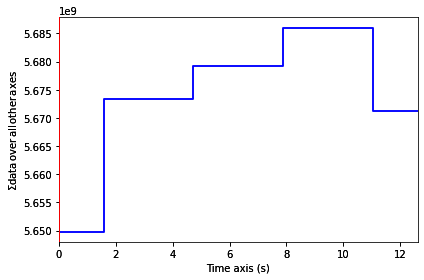

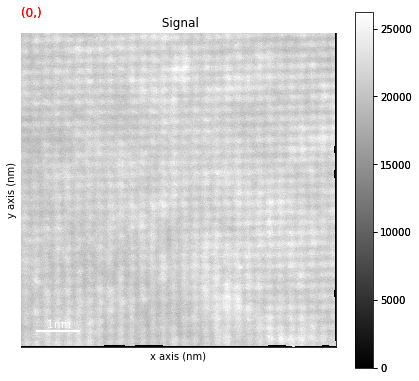

In [24]:
images_deformed.plot()

Ideally one would apply the corrections to the spectra as follows, unfortunately this doesn't really work with hyperspy. See the other notebook for mitigation strategies

In [25]:
corrected_spectrum = calculation.apply_deformations_to_spectra(data[-1], index=5)

Processed frame 1/5
Processed frame 2/5
Processed frame 3/5
Processed frame 4/5
Processed frame 5/5


In [26]:
corrected_spectrum

<LazyEDSTEMSpectrum, title: , dimensions: (512, 512|4096)>

In [ ]:
corrected_spectrum.save("data/corrected_spectrum.hspy")

# How is `apply_deformations_to_spectra` working

In [32]:
from hyperspy._signals.eds_tem import LazyEDSTEMSpectrum
import numpy as np
from scipy import ndimage

def deform_data(stack, deformations):
    """
    Apply X and Y deformation fields to a stack of images or a spectrum
    map in place

    Parameters
    ----------
    stack : hs.signals.Signal2D
        Stack of images
    deformations : (X, Y), with X and Y same size as images
        Deformation fields, must be same size as  the data

    Returns
    -------
    result : hs.signals.Signal2d
    """
    defX, defY = deformations
    w, h = stack.data.shape[-2:]
    coords = \
        np.mgrid[0:h, 0:w] + np.multiply([defY, defX], (np.max([h, w])-1))

    def mapping(x):
        return ndimage.map_coordinates(x, coords, order=0,
                                       mode="constant")
    return stack.map(mapping, inplace=False, parallel=True, ragged=False)


def apply_deformations_to_spectra(calc, specmap, index=None):
    if specmap.data.ndim != 4:
        raise ValueError("Spectrum map should be provided as individual "
                         "frames. Please read in with flag "
                         "sum_frames=False.")
    if index is None:
        index = calc._default_index
    # extract the list of calculated frames from the relevant config file
    frames = calc._get_frame_list(index)
    numframes = len(frames)
    newshape = (specmap.axes_manager[0].size,
                specmap.axes_manager[1].size,
                specmap.axes_manager[3].size)
    axes = specmap.axes_manager.as_dictionary()
    axes["axis-0"]["size"] = numframes
    axlist = [axes["axis-1"], axes["axis-2"], axes["axis-3"]]
    newds = LazyEDSTEMSpectrum(np.zeros(newshape), axes=axlist)
    for j, i in enumerate(frames):
        # import X and Y displacements as 2D arrays from the right file
        defs = calc.get_deformations_frame(i, image_set_index=index)
        to_add = deform_data(specmap.inav[:, :, i].T, defs).T
        newds = newds + to_add
        print(f"Processed frame {j+1}/{numframes}")
    return newds



In [33]:
defspec = apply_deformations_to_spectra(calculation, data[-1], index=5)

Processed frame 1/5
Processed frame 2/5
Processed frame 3/5
Processed frame 4/5
Processed frame 5/5


In [34]:
defspec

<LazyEDSTEMSpectrum, title: , dimensions: (512, 512|4096)>